<a href="https://colab.research.google.com/github/abubakerKhaled/Cars-Classification/blob/main/04_ViT_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import random
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import StratifiedShuffleSplit
from google.colab import drive

drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/MyDrive/StanfordCars_Project'
MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
RESULTS_PATH = os.path.join(PROJECT_PATH, 'results')
DATA_PATH = os.path.join(PROJECT_PATH, 'stanford_cars_top20')

os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if os.path.exists(DATA_PATH):
    print(f"Found data at: {DATA_PATH}")
    full_dataset = datasets.ImageFolder(root=DATA_PATH)
    targets = full_dataset.targets
    class_names = full_dataset.classes

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(splitter.split(np.zeros(len(targets)), targets))

    class CustomDataset(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform: x = self.transform(x)
            return x, y
        def __len__(self): return len(self.subset)

    train_dataset = CustomDataset(Subset(full_dataset, train_idx), transform=train_transform)
    val_dataset = CustomDataset(Subset(full_dataset, val_idx), transform=val_transform)

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    print("Data Ready.")
else:
    print("Error: Check Data Path")

Mounted at /content/drive
Found data at: /content/drive/MyDrive/StanfordCars_Project/stanford_cars_top20
Data Ready.


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):

        x = self.proj(x)

        x = x.flatten(2)

        x = x.transpose(1, 2)

        return x

dummy_img = torch.randn(1, 3, 224, 224)
patcher = PatchEmbedding()
output = patcher(dummy_img)
print(f"Input Image: {dummy_img.shape}")
print(f"Output Patches: {output.shape}")

Input Image: torch.Size([1, 3, 224, 224])
Output Patches: torch.Size([1, 196, 768])


In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=20, embed_dim=768):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, 3, embed_dim)

        self.n_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.n_patches, embed_dim))

    def forward(self, x):
        n_samples = x.shape[0]

        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(n_samples, -1, -1)

        x = torch.cat((cls_token, x), dim=1)

        x = x + self.pos_embed

        return x

model = ViT()
dummy_img = torch.randn(1, 3, 224, 224)
output = model(dummy_img)
print(f"Input Shape: {dummy_img.shape}")
print(f"Output Shape: {output.shape}")

Input Shape: torch.Size([1, 3, 224, 224])
Output Shape: torch.Size([1, 197, 768])


In [ ]:
class Attention(nn.Module):
    def __init__(self, dim=384, num_heads=6):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

atten_layer = Attention(dim=384, num_heads=6)
dummy_input = torch.randn(1, 197, 384)
output = atten_layer(dummy_input)
print(f"Tiny Attention Output: {output.shape}")

Tiny Attention Output: torch.Size([1, 197, 384])


In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features * 4

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=dim * 4)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))

        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=20,
                 embed_dim=384, depth=4, num_heads=6):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, 3, embed_dim)
        self.num_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=0.1)

        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]

        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        x = self.blocks(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]

        x = self.head(cls_token_final)

        return x

model_vit = VisionTransformer()
print(f"ViT-Tiny Created! Parameters: {sum(p.numel() for p in model_vit.parameters()):,}")

ViT-Tiny Created! Parameters: 7,477,652


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    since = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print(f"Engine Start. Device: {device}")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_vit.parameters(), lr=0.0003, weight_decay=0.01)

trained_vit, vit_history = train_model(
    model_vit,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=15
  )

Engine Start. Device: cuda
Epoch 1/15
----------
train Loss: 3.1016 Acc: 0.0489
val Loss: 3.0225 Acc: 0.0737
Epoch 2/15
----------
train Loss: 3.0211 Acc: 0.0661
val Loss: 2.9928 Acc: 0.1158
Epoch 3/15
----------
train Loss: 2.9785 Acc: 0.0661
val Loss: 2.9560 Acc: 0.1263
Epoch 4/15
----------
train Loss: 2.9481 Acc: 0.0925
val Loss: 2.9452 Acc: 0.0684
Epoch 5/15
----------
train Loss: 2.9365 Acc: 0.0925
val Loss: 2.9101 Acc: 0.1579
Epoch 6/15
----------
train Loss: 2.8997 Acc: 0.1162
val Loss: 2.8913 Acc: 0.1263
Epoch 7/15
----------
train Loss: 2.8858 Acc: 0.1255
val Loss: 2.9416 Acc: 0.1263
Epoch 8/15
----------
train Loss: 2.8821 Acc: 0.1189
val Loss: 2.9133 Acc: 0.1526
Epoch 9/15
----------
train Loss: 2.8673 Acc: 0.1255
val Loss: 2.8776 Acc: 0.1316
Epoch 10/15
----------
train Loss: 2.8287 Acc: 0.1427
val Loss: 2.9619 Acc: 0.1263
Epoch 11/15
----------
train Loss: 2.8303 Acc: 0.1374
val Loss: 2.9185 Acc: 0.1263
Epoch 12/15
----------
train Loss: 2.8145 Acc: 0.1347
val Loss: 2.894

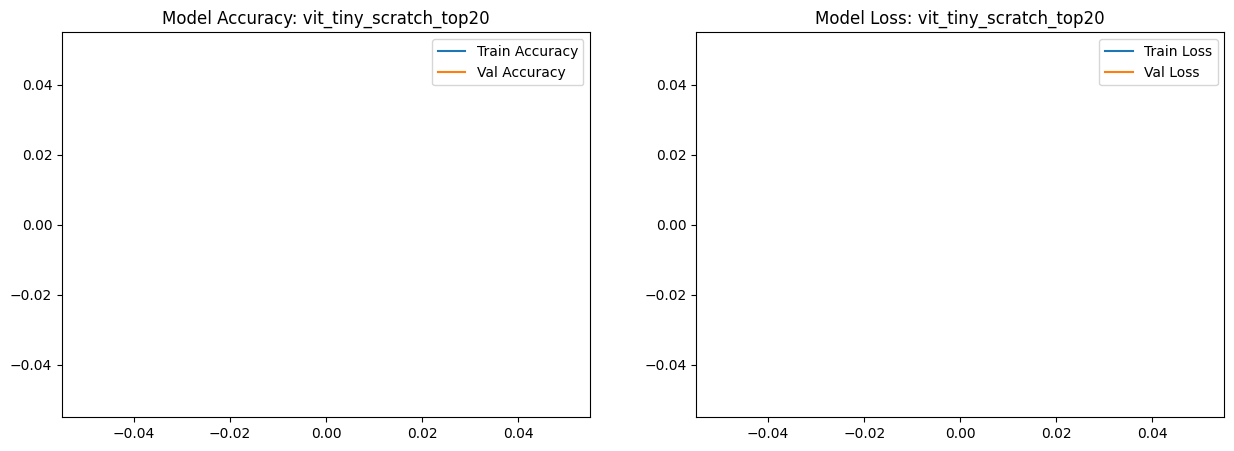

Generating Report...
                                          precision    recall  f1-score   support

                      Audi S6 Sedan 2011       0.11      0.11      0.11         9
       Bentley Continental GT Coupe 2007       0.00      0.00      0.00         9
     Cadillac Escalade EXT Crew Cab 2007       0.20      0.22      0.21         9
             Chevrolet Corvette ZR1 2012       0.00      0.00      0.00        10
             Chevrolet Malibu Sedan 2007       0.00      0.00      0.00         9
                 Chrysler 300 SRT-8 2010       0.00      0.00      0.00        10
                  Dodge Durango SUV 2007       0.00      0.00      0.00         9
              Eagle Talon Hatchback 1998       0.07      0.22      0.11         9
                      Ford GT Coupe 2006       0.31      0.44      0.36         9
                     GMC Savana Van 2012       0.22      1.00      0.35        14
              Geo Metro Convertible 1993       0.44      0.44      0.44     

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_and_save(model, history, val_loader, class_names, save_name):

    MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
    RESULTS_PATH = os.path.join(PROJECT_PATH, 'results')
    os.makedirs(MODELS_PATH, exist_ok=True)
    os.makedirs(RESULTS_PATH, exist_ok=True)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history['train_acc'], label='Train Accuracy')
    ax[0].plot(history['val_acc'], label='Val Accuracy')
    ax[0].set_title(f'Model Accuracy: {save_name}')
    ax[0].legend()

    ax[1].plot(history['train_loss'], label='Train Loss')
    ax[1].plot(history['val_loss'], label='Val Loss')
    ax[1].set_title(f'Model Loss: {save_name}')
    ax[1].legend()
    plt.savefig(f"{RESULTS_PATH}/{save_name}_curves.png")
    plt.show()

    print("Generating Report...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    torch.save(model.state_dict(), f"{MODELS_PATH}/{save_name}.pth")

    final_data = {"history": history, "report": report_dict}
    with open(f"{RESULTS_PATH}/{save_name}_metrics.json", 'w') as f:
        json.dump(final_data, f)

    print(f"Saved {save_name} to Drive.")

evaluate_and_save(
    trained_vit,
    vit_history,
    val_loader,
    class_names,
    "vit_tiny_scratch_top20"
)